# Time Series Modelling Part Two

### What we covered last time

In the previous session we looked at a series of increasingly complex time series processes and discussed how to model them. We started with white noise and then built things up from there, covering autoregressive and moving average processes and ending by introducing differencing. This at last gave us a process that looked more like the kind of thing we deal with in our working lives. The ARIMA(1,1,0) process which we ended on had a trend but did not display any kind of seasonality. We will begin this session by looking at how we add seasonal patterns to the ARIMA process. 

### What we will cover today

1. Seasonal ARIMA, how to identify the process, fit the model and make a forecast.
2. So far we have not been able to incorporate exogenous variables into the forecast. For many of the time series you deal with, exogenous variable are unavoidable. We will look at how the seasonanal ARIMA model can be extended to handle exogenous variables.
3. We need something in our toolkit to handle the more dynamic type of time series process. For example we might have a situation where a seasonal pattern is fading out and a new kind of pattern is emerging. This is a big area but we will touch on it with a brief look at exponential smoothing methods.


## Hands on

We will continue the format of the last session, generating our own data to illustrate the use of the models.

First we need to set up our environment.

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.style.use('ggplot')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.random.seed(999)
num_time_periods = 2*365

### Scenario 8: Multiplicative seasonal $ARIMA(1,0,0)(0,1,0)_7$

Recall Scenario 7 from the last session. There we modelled the day-on-day differences as an AR(1) process. What if it were the week-on-week differences that followed such a process.

#### The generative model

Using our differencing operator syntax the model can be described as follows:

$(1-L^7)Y_t = \mu + \theta Y_{t-1} + \epsilon_t$

$Y_t - Y_{t-7} = \mu + \theta Y_{t-1} + \epsilon_t$

Where

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \theta < -1 $

The ARIMA specification for this process $ARIMA(1,0,0)(0,1,0)_7$

It's probably a good time to get to grips with this way of describing the process so here are some examples:

1. $ARIMA(1,1,0)$ The differenced data follows an AR(1) process.
2. $ARIMA(1,2,0)$ The double differenced data (difference the differences) follows an AR(1) process.
3. $ARIMA(0,1,1)$ The differenced data follows an MA(1) process.
4. $ARIMA(0,1,3)$ The differenced data follows an MA(3) process.

Now it starts to get difficult!

1. $ARIMA(1,0,0)(0,1,0)_7$ The week on week differenced data follows an AR(1) process.
2. $ARIMA(1,0,3)(0,1,0)_7$ The week on week differenced data follows an ARMA(1,3) process.
3. $ARIMA(1,1,0)(0,1,0)_7$ The differenced week on week differences follows an AR(1) process.


Let's just think for a moment about our $ARIMA(1,0,0)(0,1,0)_7$ process. What we are saying here is that after we have adjusted for the weekly pattern, there is some carry over in to the next value in the time series. If there was a big surge in viewer numbers *for a Tuesday* then we might expect viewer numbers to be big *for the Wednesday*. But there's another kind of pattern we might also be interested in capturing. What if a big surge in viewer numbers *for a Tuesday* has a carry over to the following Tuesday. This might happen for example if there were a group of people who have free time on Tuesdays. Their interest was piqued (by an offer) on one Tuesday and they came back on the next Tuesday. We would describe this situation with a $ARIMA(1,0,0)(1,1,0)_7$ model. 

Let's see if we can describe situations that would be modelled by the following.

1. $ARIMA(0,0,0)(1,1,0)_7$
1. $ARIMA(0,0,1)(0,1,1)_7$
1. $ARIMA(1,1,0)(1,1,0)_7$

Back to our much simpler $ARIMA(1,0,0)(0,1,0)_7$ situation!

#### The technique

First we generate the data

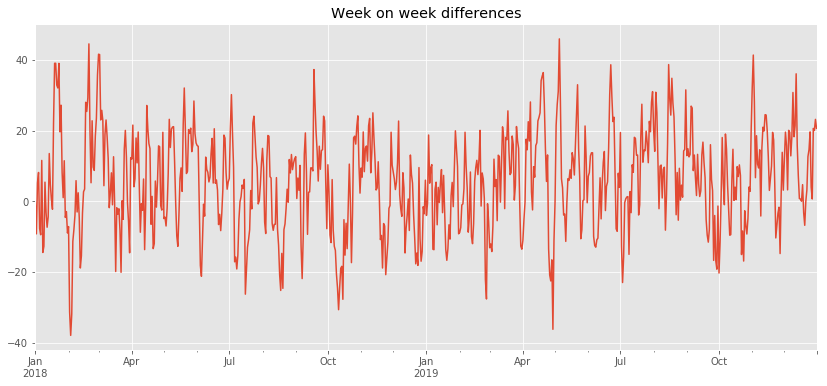

In [2]:
np.random.seed(123)
date_index = pd.date_range('2018-01-01', periods = num_time_periods, freq = 'D')
wow_differences = [0]
theta = 0.7
mu = 1.7
for t in range(num_time_periods-1):
    next_value = mu + theta*wow_differences[t] + np.asscalar(np.random.normal(0, 10, 1))
    wow_differences.append(next_value)
    
    
ds = pd.Series(wow_differences, index = date_index)
fig, ax = plt.subplots(figsize = (14,6))
ax = ds.plot(title = "Week on week differences")

To recover the original data I will need to do a separate cumulative sum for each day of the week.

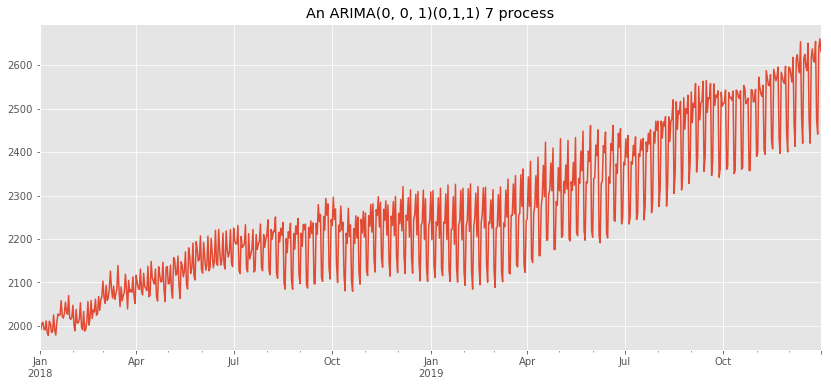

In [3]:
undifferenced = []

for i in range(num_time_periods):
    if i > 6:
        ud = wow_differences[i] + undifferenced[i-7]
    else:
        ud = wow_differences[i]
    undifferenced.append(ud)


ts = pd.Series(undifferenced, index = date_index) + 2000 
fig, ax = plt.subplots(figsize = (14,6))
ax = ts.plot(title = "An ARIMA(0, 0, 1)(0,1,1) 7 process")

### How would you identify a seasonal ARIMA process?

It's fairly clear that this is a non stationary series with a weekly pattern but if we were in any doubt we could look at the acf plot.


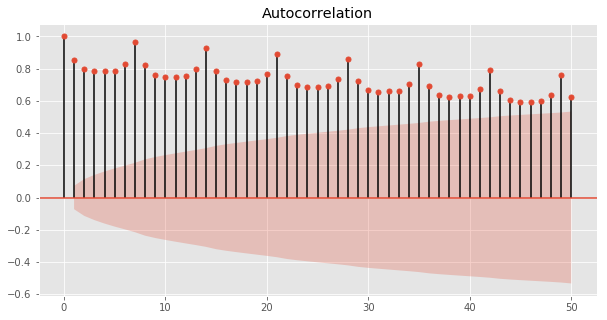

In [4]:
with mpl.rc_context():
    mpl.rc("figure", figsize = (10,5))
    plot_acf(ts, lags = 50)

So the next step is to apply differencing to the data and re-examine the process.

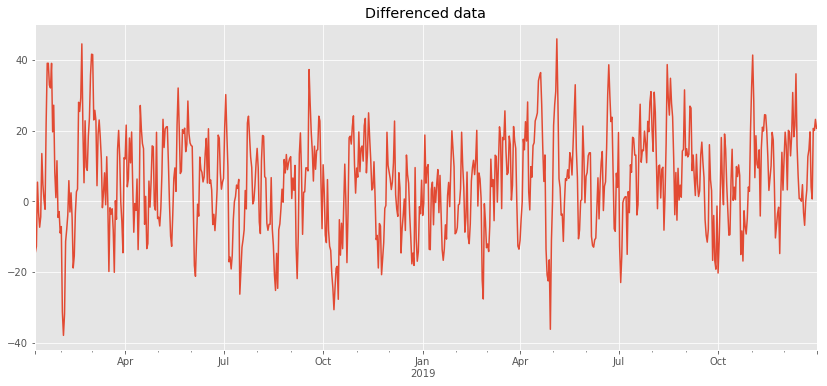

In [5]:
ts_diff = ts.diff(7).dropna()
fig, ax = plt.subplots(figsize = (14,6))
ax = ts_diff.plot(title = "Differenced data")

This appears to be stationary so we can now use the acf and pacf to identify the AR and MA orders.

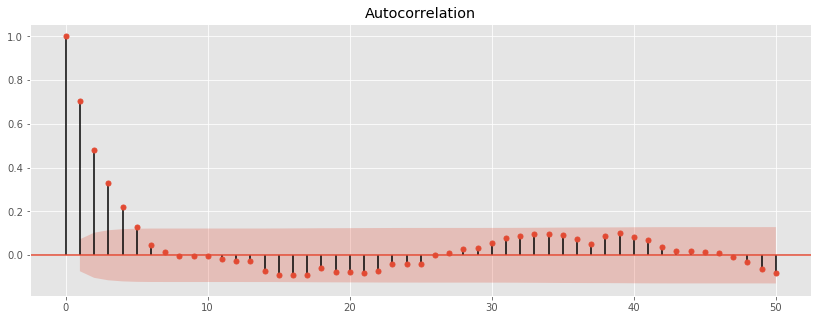

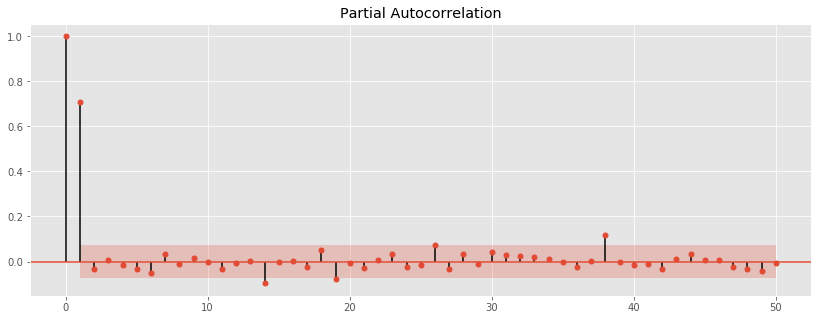

In [6]:
with mpl.rc_context():
    mpl.rc("figure", figsize = (14,5))
    plot_acf(ts_diff, lags = 50)
    plot_pacf(ts_diff, lags = 50)

The acf tails off and pacf cuts off after one so we identify an AR(1) process for the differenced data.

### How do you fit a seasonal ARIMA model?

This is done using the SARIMAX function.

In [7]:
model = SARIMAX(ts, trend = "c", order = (1,0,0), seasonal_order = (0,1,0,7), simple_differencing = True)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             DS7.y   No. Observations:                  723
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 7)   Log Likelihood               -2681.718
Date:                           Fri, 15 Feb 2019   AIC                           5369.437
Time:                                   14:45:23   BIC                           5383.187
Sample:                               01-08-2018   HQIC                          5374.744
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6557      0.394      4.204      0.000       0.884       2.428
ar.L1          0.7079      0.027     26.092      0.000       0.655       0.761
sigma2        97.4623      5.315     18.337      0.000      87.045     107.880
===================================================================================
Ljung-Box (Q):                       37.69   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.57   Prob(JB):                         0.69
Heteroskedasticity (H):               0.93   Skew:                            -0.04
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

An analysis of the residuals suggest we have a good fit.

[ 0.53995959  0.69988007  0.86997343  0.93717886  0.97116304  0.6138454
  0.71348776  0.75916707  0.83559586  0.87355339]


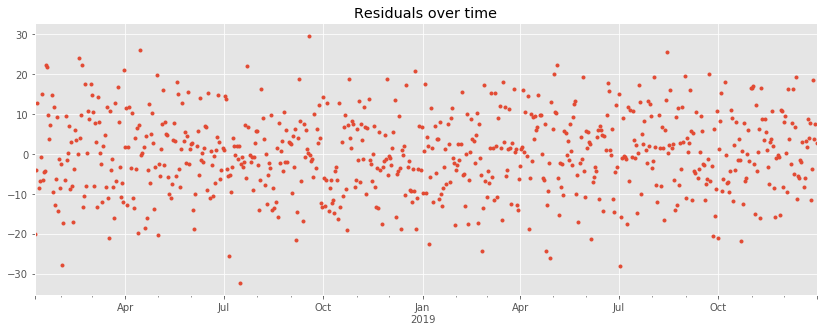

In [8]:
ts_res = pd.Series(model_fit.resid)
fig, ax = plt.subplots(figsize = (14,5))
ax = ts_res.plot(title = "Residuals over time", style = '.')

p_values = acorr_ljungbox(ts_res, 10)[1]
print(p_values)

### How do we forecast a seasonal ARIMA process?

The predict and forecast methods output forecasts for the differenced data. They need to be summed to produce forecasts for the original data.

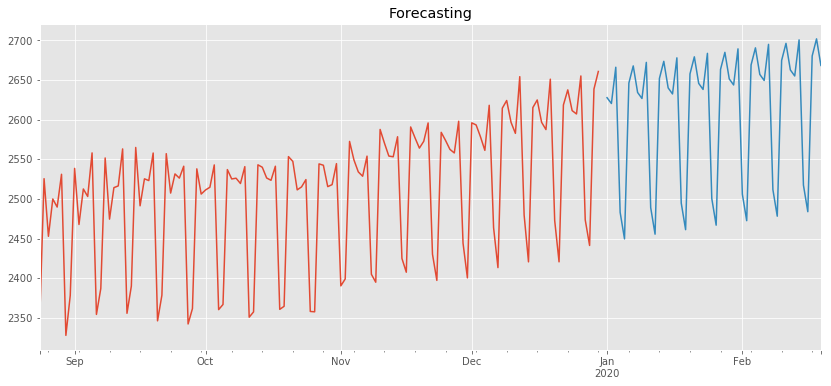

In [9]:
forecast = model_fit.forecast(50)
undifferenced = ts[722:729].values.tolist()
for i in range(50):
    undifferenced.append(undifferenced[i] + forecast[i])
fts = pd.Series(undifferenced[7:], index = forecast.index)

fig, ax = plt.subplots(figsize = (14,6))
ax = ts[600:729].plot(title = "Forecasting")
ax = fts.plot()

### Scenario 9: ARIMAX

So imagine now that our viewer numbers follow a regular weekly pattern, with an upwards trend but every now and again this pattern is interupted with a temporary surge of viewers caused by the launch of a big programme. This calls for an ARIMAX model.

#### The generative model

The best way to think about this is as a regression model where the errors follow an ARIMA process. So it looks like this.

$Y_t = \alpha + \beta x_t + U_t$

Where

$(1-L^7)U_t = \mu + \theta U_{t-1} + \epsilon_t$

With

$\epsilon_t \sim N(0, \sigma^2)$ 

and $-1 < \theta < -1 $


Note that Rob Hyndman (A recognised expert in time series modelling) [recommends](https://robjhyndman.com/hyndsight/arimax/) that for ease of interpretation we push the seasonal and trend components into the regression part of the model and model the errors as an ARMA process. This does seem sensible. However we will proceed with the ARIMAX example, and I'll leave you to think about how to carry out Rob Hyndham's suggestions.

#### The technique

First we  create the launch data. We then add it to the previously created series.

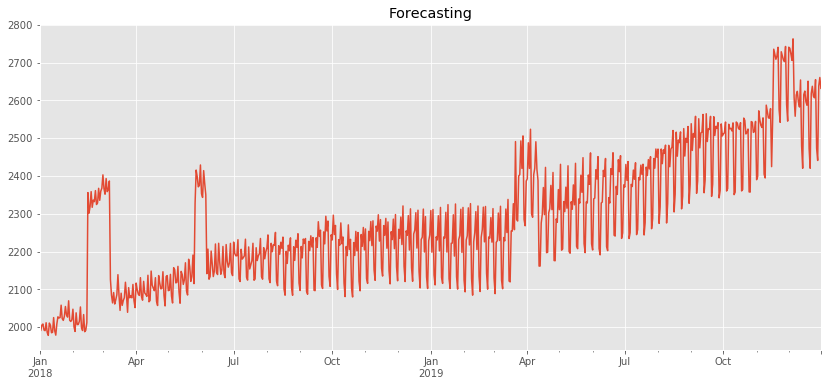

In [10]:
launches = [0]*730
launches[45:65] = [300]*21
launches[145:156] = [222]*11
launches[444:466] = [145]*21
launches[684:706] = [145]*22

pcts = ts + launches
fig, ax = plt.subplots(figsize=(14,6))
ax = pcts.plot(title="Forecasting")

In [11]:
model = SARIMAX(ts, pcts, trend = "c", order = (1,0,0), seasonal_order = (0,1,0,7), simple_differencing = True)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             DS7.y   No. Observations:                  723
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 7)   Log Likelihood               -2640.477
Date:                           Fri, 15 Feb 2019   AIC                           5288.953
Time:                                   14:45:25   BIC                           5307.287
Sample:                               01-08-2018   HQIC                          5296.030
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4048      0.372      3.781      0.000       0.677       2.133
0              0.0975      0.005     18.486      0.000       0.087       0.108
ar.L1          0.7253      0.027     27.174      0.000       0.673       0.778
sigma2        86.9486      4.771     18.225      0.000      77.598      96.299
===================================================================================
Ljung-Box (Q):                       34.91   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.70   Prob(JB):                         0.89
Heteroskedasticity (H):               0.83   Skew:                             0.04
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now to create a forecast the SARIMAX forecasts need to be undifferenced and combined with a forecast of the exogenous variable. *Write some code to do this.*

### Scenario 10: Exponential smoothing

We are going to take a quick look at a completely different kind of forecasting. Unlike ARIMA, exponential smoothing is not based on the idea of a statistical model. In fact it has more in common with some of the filtering techniques used in signal processing. The basic idea is that a forecasting is based on previous values in the series in such as way that the importance of the value to the forecast decays the further back in time you go.

#### The generative model

The basic model for exponential smoothing is:

$s_t = \alpha \cdot x_t + (1-\alpha) \cdot s_{t-1} = s_{t-1} + \alpha \cdot (x_t - s_{t-1})$

Where $0<\alpha<1$

*What happens as $\alpha$ increases?

To accommodate time series with a trend we use double exponential smoothing.

$s_{t} = \alpha x_{t} + (1-\alpha)(s_{t-1} + b_{t-1})$

$b_{t} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}$

*Can you see from the formula how this works?*

Finally triple exponential smoothing takes care of seasonality in addition to trend.

$s_{t} = \alpha (x_{t}-c_{t-L}) + (1-\alpha)(s_{t-1} + b_{t-1})$

$b_{t} = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}$

$c_{t} = \gamma (x_{t}-s_{t-1}-b_{t-1})+(1-\gamma)c_{t-L}$


*Again interpret the formula.*

#### The technique

We'll try triple exponential smoothing on the data set we created for seasonal ARIMA.

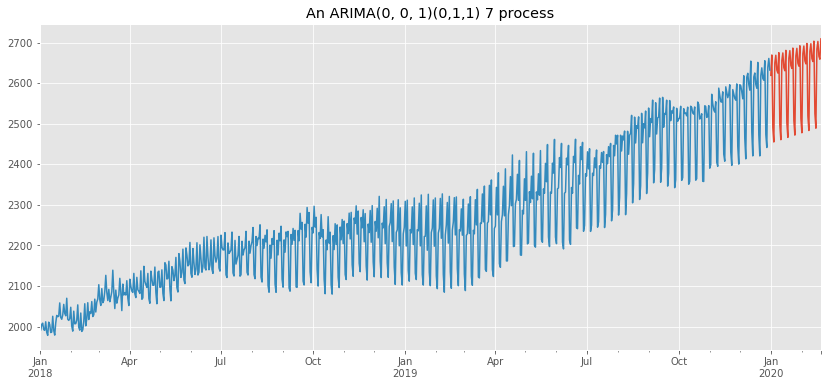

In [12]:
model = ExponentialSmoothing(ts, trend = 'add', seasonal = 'add', seasonal_periods = 7).fit()
pred = model.predict(num_time_periods,num_time_periods + 50)
fig, ax = plt.subplots(figsize = (14,6))
ax = pred.plot(title = "An ARIMA(0, 0, 1)(0,1,1) 7 process")
ax = ts.plot(title = "An ARIMA(0, 0, 1)(0,1,1) 7 process")

And then on the data used for the ARIMAX model.

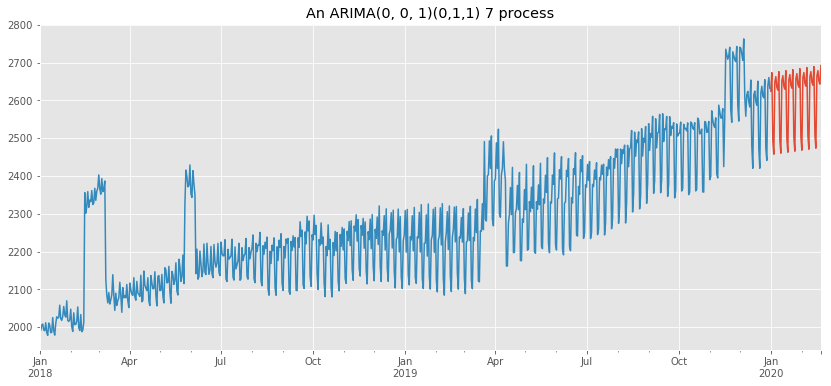

In [13]:
model = ExponentialSmoothing(pcts, trend = 'add', seasonal = 'add', seasonal_periods = 7).fit()
pred = model.predict(num_time_periods,num_time_periods + 50)
fig, ax = plt.subplots(figsize = (14,6))
ax = pred.plot(title = "An ARIMA(0, 0, 1)(0,1,1) 7 process")
ax = pcts.plot(title = "An ARIMA(0, 0, 1)(0,1,1) 7 process")

Exponential smoothing is slightly confused by the last surge caused by the exogenous variable. It causes the upwards trend to level off. *Can you explain why?*

## Using prophet

To finish off let's look at the prophet package created by Facebook. Here's how they describe it:

> Producing high quality forecasts is not an easy problem for either machines or for most analysts. We have observed two main themes in the practice of creating a variety of business forecasts:

> * Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.
> * Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience.

> ... We have found Prophet’s default settings to produce forecasts that are often accurate as those produced by skilled forecasters, with much less effort. With Prophet, you are not stuck with the results of a completely automatic procedure if the forecast is not satisfactory — an analyst with no training in time series methods can improve or tweak forecasts using a variety of easily-interpretable parameters. We have found that by combining automatic forecasting with analyst-in-the-loop forecasts for special cases, it is possible to cover a wide variety of business use-cases. 

They are probably over-claiming a bit here. The ideal is probably that an analyst with some specialised knowledge tweaks the results!

It's certainly easy to use.


In [18]:
from fbprophet import Prophet

ts_prophet = pd.DataFrame({"ds": ts.index, "y": ts})

m = Prophet(yearly_seasonality = False, daily_seasonality = False)
m.fit(ts_prophet)

future = m.make_future_dataframe(periods = 20)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
745,2020-01-16,2667.99,2628.25,2709.05
746,2020-01-17,2523.25,2480.24,2562.32
747,2020-01-18,2513.16,2471.89,2555.20
748,2020-01-19,2635.70,2595.06,2679.59
749,2020-01-20,2617.06,2575.12,2659.72


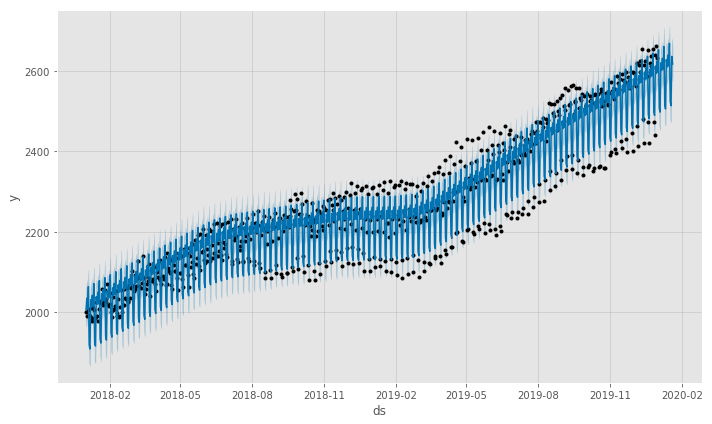

In [19]:
fig1 = m.plot(forecast, uncertainty = True)

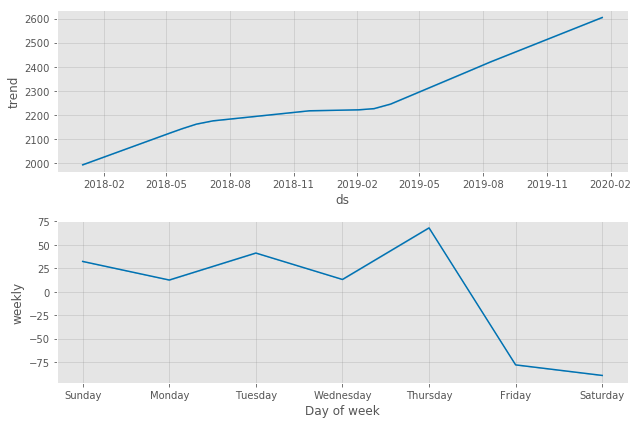

In [20]:
fig2 = m.plot_components(forecast)

There's some amazing features including the ability to an add an exogenous holiday variable for the country you are in! I urge you to check out the [documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

## Now your turn!

A reminder of the steps you need to go through:

1. A visual inspection of your time series data. Does there appear to be a trend? Seasonality? Disruption by exogenous variables?
2. If no exogenous variables are involved then proceed with the Box Jenkins approach:
    1. Difference the data until it appears to be stationary
    2. Use the acf and pacf plots to identify the AR and MA orders for the differenced data
    3. Fit an ARIMA model
    4. Check that the residuals are a white noise process
    5. Try other possible candidate models and compare their fit with your model
3. If there are exogenous variables then probably the wisest approach (following Rob Hyndham) is to follow the process for building econometric models based on regression, using IID errors initially and then develop an ARIMA model for the error by analysing the residuals. Alternatively you could try using exponential smoothing.
4. Compare your handcrafted results with the forecasts from Prophet.

